DBSCAN
===============
_Density-based spatial clustering of applications with noise_
***

TODO: Explanantion of DBSCAN

Clustering Of _Waking-up_ and _Sleep_ timings
=================
*****************
The following algorithm below will cluster sleep periods using the [DBSCAN algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) from the [scikit-learn library](http://scikit-learn.org/)

Input data requirements
---------------------
****
The data input is expected to follow the following format:

<table>
<th>TODO</th>
</table>

In [161]:
%matplotlib inline
###########################################IMPRORTS#########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import DistanceMetric
import eps_min_pts as eps_And_MinPts
import helper_adl as h
from matplotlib.backends.backend_pdf import PdfPages
###########################################IMPRORTS#########################################


# To return value in mins / total mins in one day
def to_mins(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return (x.value - pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day)).value) / (60 * (10**9))

# Helper method to convert values to radian
def convert_to_radian(x):
    return ((x / (24*60)) * 2 * pi)

# Returns a distance matrix (a numpy array)
def get_x_from_df(series):
    
    # Vectorizing to_mins and to_radian functions
    tmin = np.vectorize(to_mins)
    trad = np.vectorize(convert_to_radian)

    # Converting series of timestamp -> minutes / total minuites in a day -> radian
    input_rad = trad(tmin(series))

    # Convert time to rad points   
    X = input_rad[None,:] - input_rad[:,None]

    # Assign 'shortest distance to each point
    X[((X > pi) & (X <= (2*pi)))] = X[((X > pi) & (X <= (2*pi)))] -(2*pi)
    X[((X > (-2*pi)) & (X <= (-1*pi)))] = X[((X > (-2*pi)) & (X <= (-1*pi)))] + (2*pi) 
    X = abs(X)

    return X,input_rad

# Returns output from sklearn DBSCAN method
def dbscan(eps, min_pts, X, metric='precomputed'):
    db = DBSCAN(eps, min_pts, metric)
    db.fit(X)
    return db.labels_, db.components_, db.core_sample_indices_

def configure_polar_plot(axes):
    xticklabels = [str(x) for x in range (0,24)]
#     xticklabels = [str(x) for x in (np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi))]
    axes.set_xticks(np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi))
    axes.set_xticklabels(xticklabels)
    axes.set_theta_zero_location('N')
    axes.set_theta_direction(-1)
    axes.set_ylim([0,1])
    axes.set_yticks([0.8,0.6])
    axes.set_yticklabels(['Sleep-Start', 'Sleep-End'])
    
    return axes

def plot_clusters(labels, rad_tseries, axes, ring):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k,col in zip(unique_labels, colors):
        marker = '.'
        ms = 30.0
        if k == -1:
            col='k'
            marker = 'x'
            ms = 8.0

        indices_of_k, = np.where(labels == k)
        data = rad_tseries.take(indices_of_k)
        axes.plot(data, [ring for x in data], color=col, marker=marker, linestyle='none', ms=ms, mec='k')
        

File name:  sleep/sleep-aggregate_2016-01_S042.csv
eps:  0.0420915237939  minPts:  6.0
eps:  0.0656461964906  minPts:  5.5
eps:  0.634580716923  minPts:  15.5
Number of clusters for start sleep time:  2
Number of clusters for end sleep time:  3
Number of clusters for X3(pairwise) cluster:  1
{0, 1}
[ 0  1  2  3  4  5  9 11 15 17 21 24 27 28]
[ 6  7  8 10 12 13 14 16 18 19 20 22 23 25 26]
{0: (0.028361600344907853, 2.7780551148098076), 1: (0.0085084801034723562, 2.732531110153622)}


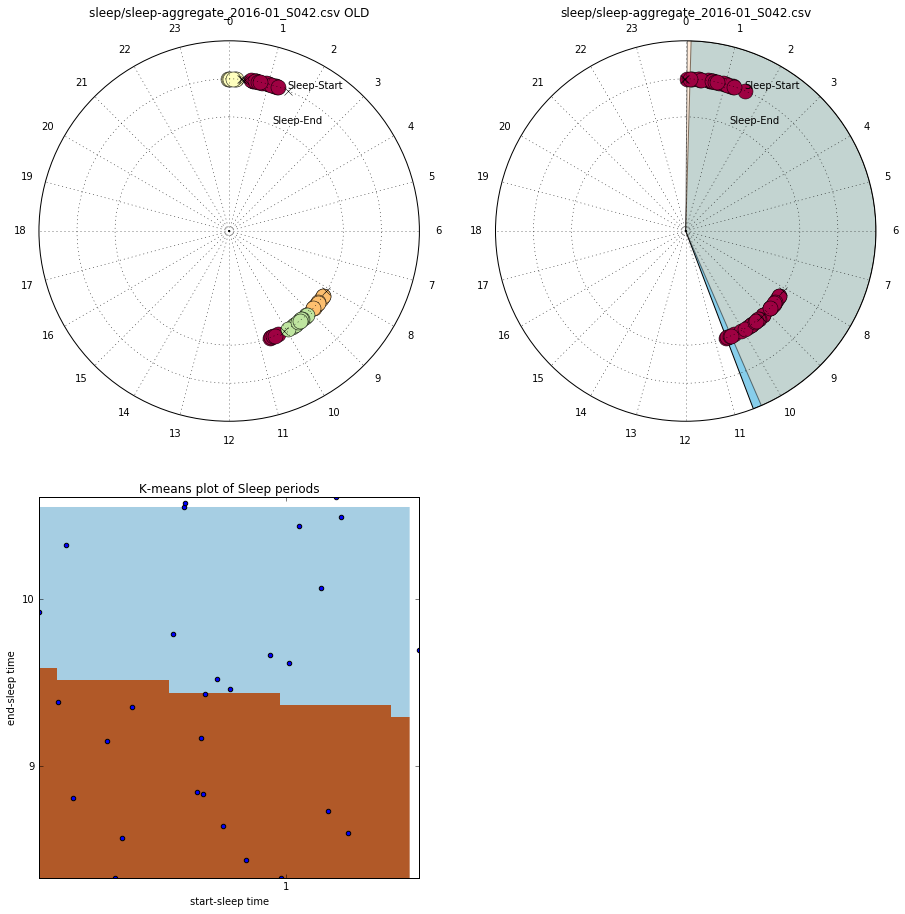

Elasped Time:  1.608 seconds


In [188]:
# Code
# Start timer:
time_now = time.time()

### Globals ###
file_dir = 'sleep'
# Perform clustering on files 1 to 10
# indexes = [str(x) for x in range(1,10)]
index = '9'
#sleep/sleep-aggregate_2016-01_S042.csv
file_name = ''.join([file_dir,'/','sleep-aggregate_2016-01_S042.csv'])
# print file name
print('File name: ', file_name)

# Get dataframe containing readings from sensor reading, exclude 
df = pd.read_csv(file_name, delimiter=',', usecols=[x for x in range(1,7)],parse_dates=[1])
column_names = list(df.columns.values)

# X is a distance matrix.
# Set 'X1' as sleep_start timings
X1,X1_rad_series = get_x_from_df(df['sleep_start'])
# Set 'X2' as sleep_end timings
X2,X2_rad_series = get_x_from_df(df['sleep_end'])

# Create X3 DataFrame from X to test pairwise clusters
# Data has already been optimized; Values are in radian, and shortest distances
# have been assigned.
X3 = pd.DataFrame()
X3['sleep_start'] = X1_rad_series
X3['sleep_end'] = X2_rad_series


# Calculate eps and minPts dynamically.
eps_X1, min_pts_X1 = eps_And_MinPts.knee_calculate_eps_minPts(X1)
print('eps: ', eps_X1 , ' minPts: ' , min_pts_X1)
eps_X2, min_pts_X2 = eps_And_MinPts.knee_calculate_eps_minPts(X2)
print('eps: ', eps_X2 , ' minPts: ' , min_pts_X2)
distance = DistanceMetric.get_metric('euclidean')
X3_dist_matrix = distance.pairwise(X3)
eps_X3, min_pts_X3 = eps_And_MinPts.knee_calculate_eps_minPts(X3_dist_matrix)
print('eps: ', eps_X3 , ' minPts: ' , min_pts_X3)

# sk-learn dbscan
X1_label, X1_components, X1_csi = dbscan(eps_X1, min_pts_X1, X1)
X2_label, X2_components, X2_csi = dbscan(eps_X2, min_pts_X2, X2)
db3 = DBSCAN(eps_X3, min_pts_X3, metric='precomputed').fit(X3_dist_matrix)
X3_label, X3_components, X3_csi = db3.labels_, db3.components_, db3.core_sample_indices_

# Flatten X3 to a matrix to plot out values.
X3_matrix = X3.as_matrix()
X3_matrix = X3_matrix.T

# - 1 if -1 exist in labels because -1 is used to denote noise
X1_no_clusters = len(set(X1_label)) - (1 if -1 in X1_label else 0)
print('Number of clusters for start sleep time: ', X1_no_clusters )
X2_no_clusters = len(set(X2_label)) - (1 if -1 in X2_label else 0)
print('Number of clusters for end sleep time: ', X2_no_clusters )
X3_no_clusters = len(set(X3_label)) - (1 if -1 in X3_label else 0)
print('Number of clusters for X3(pairwise) cluster: ', X3_no_clusters )


# XX is a df containing X1 and X2, used for Kmeans clustering of 2 clusters
# XX = pd.DataFrame();

# print('len of X1_rad_series, ', len(X1_rad_series))
# print('len of X2_rad_series, ', len(X2_rad_series))
# print('len of np.where for X1_labels ', len(X1_label ))
# print('len of np.where for X2_labels ', len(X2_label ))

indices_of_X1_without_noise, = np.where(X1_label != -1)
# print(indices_of_X1_without_noise)
X1_no_noise = X1_rad_series[indices_of_X1_without_noise]
indices_of_X2_without_noise, = np.where(X2_label != -1)
# print(indices_of_X2_without_noise)
X2_no_noise = X2_rad_series[indices_of_X2_without_noise]

# Remove noise, prep data for kmeans
indices_of_X3_without_noise, = np.where(X3_label != -1)
X3_no_noise = X3.ix[indices_of_X3_without_noise]
# XX['X1'] = X1_no_noise
# XX['X2'] = X2_no_noise

# print('What is XX? :', XX)

# Consider case where clusters may only produce 1 cluster?
#default

# If DBSCAN produces only 1 cluster, set kmeans to 1.

# Config k-means estimator
km = KMeans(n_clusters=2,max_iter=1000, init='k-means++', precompute_distances='auto', n_jobs=-1)
# Performing fit..
km.fit(X3_no_noise)
XX_cluster_centers = km.cluster_centers_ 
XX_labels = km.labels_
XX_inertia = km.inertia_


# print('KMeans')
# print('--------------------------')
# print(XX_labels)
# print(XX_cluster_centers)
# print(XX_inertia)

# Remove noise first

km_clusters = set(XX_labels)
km_dict = {}
print(km_clusters)
for k in km_clusters:
    indices_of_k, = np.where(XX_labels == k)
    print(indices_of_k)
    X3_min = np.min(X3_no_noise['sleep_start'].ix[indices_of_k])
    X3_max = np.max(X3_no_noise['sleep_end'].ix[indices_of_k])
    # Check if min > max, swap  
    km_dict[k] = (X3_min, X3_max)
    
# print(km_dict)


# EXTRACTION OF CLUSTERS
###########################################
# cluster_dict_ = h.extract_clusters(X1_label, X1_rad_series)
# cluster_dict_keys_ = cluster_dict_.keys()
# for i in cluster_dict_keys_:
#     cluster = cluster_dict_[i]
#     print(cluster)
#     cluster_list.append(np.asscalar(i))
#     print('Cluster : ', i)
#     print('SD : ', np.std(cluster))
#     print('VAR : ', np.var(cluster))
#     print('centroid-val : ', np.median(cluster))


# print(cluster_list)
##################PLOTTING####################
# TODO: CLUSTER
fig = plt.figure(figsize=(15,15))
# fig1 = plt.figure(figsize=(6,6))
ax1 = configure_polar_plot(fig.add_subplot(221, projection='polar'))
ax2 = configure_polar_plot(fig.add_subplot(222, projection='polar'))
ax3 = fig.add_subplot(223)
ax1.set_title(file_name + ' OLD')
ax2.set_title(file_name)
ax3.set_title('K-means plot of Sleep periods')
ax3.set_xlabel('start-sleep time')
ax3.set_ylabel('end-sleep time')
xy_ticks = np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi)
xy_ticklabels = [str(x) for x in range (0,24)]
ax3.set_xticks(xy_ticks)
ax3.set_yticks(xy_ticks)
ax3.set_xticklabels(xy_ticklabels)
ax3.set_yticklabels(xy_ticklabels)
# Plot clusters for start_time and end_time for sleep periods
plot_clusters(X1_label, X1_rad_series, ax1, 0.8)
plot_clusters(X2_label, X2_rad_series, ax1, 0.6)
# Plot clusters of pairwise start_time and end_time for sleep periods
plot_clusters(X3_label, X3_matrix[0], ax2, 0.8)
plot_clusters(X3_label, X3_matrix[1], ax2, 0.6)


# Plot decision space
stepsize = .02

X3_as_matrix = X3_no_noise.as_matrix().T
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X3_as_matrix[0].min(), X3_as_matrix[0].max()
y_min, y_max = X3_as_matrix[1].min(), X3_as_matrix[1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, stepsize), np.arange(y_min, y_max, stepsize))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax3.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

ax3.scatter(X3_as_matrix[0], X3_as_matrix[1])
# Zoom in on identified cluster
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Handy dandy method to manage the width of the bar on the polar chart..
def get_bar_width(min, max):
    if min > max:
        return (h.convert_to_radian(1440)) - min + max
    else:
        return max - min
    
# if len(km_dict) ==  1:
#     print(km_dict)
#     km_clust_0_min, km_clust_0_max = km_dict[0]
#     bar = ax2.bar(km_clust_0_min,1, width=get_bar_width(km_clust_0_min, km_clust_0_max)  , bottom=0.0, color='skyblue')
# else:
print(km_dict)
km_clust_0_min, km_clust_0_max = km_dict[0]
km_clust_1_min, km_clust_1_max = km_dict[1]
bar = ax2.bar(km_clust_0_min,1, width=get_bar_width(km_clust_0_min, km_clust_0_max), bottom=0.0, color='skyblue',)
bar2 = ax2.bar(km_clust_1_min,1, width=get_bar_width(km_clust_1_min, km_clust_1_max), bottom=0.0, color='peachpuff', alpha=0.5)

plt.show()

print("Elasped Time: ", round(time.time() - time_now, 3), "seconds")
    